<a href="https://colab.research.google.com/github/KS0999/ML/blob/main/ComputerVision_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import requests
import os
import pathlib as path
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
train_dataset = torchvision.datasets.FashionMNIST(root="data",
                                                  train=True,
                                                  download=True,
                                                  transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.FashionMNIST(root="data",
                                                  train=False,
                                                  download=True,
                                                  transform=torchvision.transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:01<00:00, 14871794.05it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 275208.60it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5006070.16it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16089625.18it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
train_class = train_dataset.classes
train_class

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [5]:
train_index = train_dataset.class_to_idx
train_index

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [6]:
Batch_size = 32
train_dataloader = torch.utils.data.DataLoader(dataset = train_dataset,
                                               batch_size = Batch_size,
                                               shuffle = True)
test_dataloader = torch.utils.data.DataLoader(dataset = test_dataset,
                                               batch_size = Batch_size,
                                               shuffle = False)
print(len(train_dataset))
print(len(test_dataset))
print(len(train_dataloader))
print(len(test_dataloader))

60000
10000
1875
313


In [7]:
if os.path.isfile("helper_functions.py"):
  print("helper_functions.py is exist! ")
else:
  print("helper_function.py is not exist! Preparing for downloading ... ")
  url = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as file:
    file.write(url.content)

helper_function.py is not exist! Preparing for downloading ... 


# Some information about building CNN_model

CNN Explainer >> "https://poloclub.github.io/cnn-explainer/"

Conv2d >> "https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html"

MaxPool2d>> "https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html"

# Let's see how the conv2d works!

In [8]:
torch.manual_seed(1)
test = torch.rand(size = [32,3,64,64])
test_image = test[0]
print(f"test's shape : {test.shape}")
print(f"test_image's shape : {test_image.shape}")

test's shape : torch.Size([32, 3, 64, 64])
test_image's shape : torch.Size([3, 64, 64])


In [9]:
torch.manual_seed(1)
test_conv2d = nn.Conv2d(in_channels = 3,   # (3,64,64)
                        out_channels = 10, # replace in_channel number
                        kernel_size = 3,   # kernel_size = 3 , 64->63->62 (result's shape will be (10,62,62))
                        stride = 1,
                        padding = 0)
test_layer_1 = test_conv2d(test_image.unsqueeze(dim = 0))
test_layer_1.shape

torch.Size([1, 10, 62, 62])

In [10]:
torch.manual_seed(1)
maxpool = nn.MaxPool2d(kernel_size = 3)
result = maxpool(test_layer_1)
print(f"test's shape : {test.shape}, [batch, color_channel, height, width]")
print(f"orginal image's shape : {test_image.shape}")
print(f"after passing through the conv2d : {test_layer_1.shape} first dimensions from 3 to 10 because the out_channel")
print(f"after passing through the maxpool2d : {result.shape}\n")
print(">> adjust kernel_size and sride to change the dimensions")

test's shape : torch.Size([32, 3, 64, 64]), [batch, color_channel, height, width]
orginal image's shape : torch.Size([3, 64, 64])
after passing through the conv2d : torch.Size([1, 10, 62, 62]) first dimensions from 3 to 10 because the out_channel
after passing through the maxpool2d : torch.Size([1, 10, 20, 20])

>> adjust kernel_size and sride to change the dimensions


# Define function : eval_dict, train_model, test_model, calculate time

In [11]:
def eval_dict(model : torch.nn.Module,
              loss : torch.nn.Module,
              dataloader : torch.utils.data.DataLoader,
              accuracy_fn ):
  loss, acc = 0, 0
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X,y in dataloader :
      X, y = X.to(device), y.to(device)
      # do the forward pass
      y_pred = model(X)
      # calculate the loss & acc
      loss += loss_fn(y_pred,y)
      acc += accuracy_fn (y_true = y,
                        y_pred = torch.argmax(y_pred,dim = 1))

    loss /= len(dataloader)
    acc /= len(dataloader)
  return {
      "model":model.__class__.__name__,
      "Loss" :loss.item(),
      "Accuracy" : acc
  }

In [12]:
def train_model(model : torch.nn.Module,
                loss : torch.nn.Module,
                accuracy_fn,
                optimizer : torch.optim.Optimizer,
                dataloader : torch.utils.data.DataLoader,
                device : torch.device = device):

  train_loss, train_acc = 0, 0
  model.to(device)

  for X,y in dataloader:
    X, y = X.to(device),y.to(device)
    # do the forward pass
    y_pred = model(X)
    # calculate the loss & accuracy
    loss = loss_fn(y_pred, y)
    acc = accuracy_fn (y_true = y,
                       y_pred = torch.argmax(y_pred,dim = 1))
    train_loss += loss
    train_acc += acc
    # optimizer zero grad
    optimizer.zero_grad()
    # loss backward
    loss.backward()
    # optimizer step
    optimizer.step()
  # averager loss & accuracy
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  print(f"Train_Loss :{train_loss}, Train_Accuracy : {train_acc:.2f} %")

In [13]:
def test_model(model : torch.nn.Module,
               loss : torch.nn.Module,
               accuracy_fn,
               dataloader : torch.utils.data.DataLoader,
               device : torch.device = device):

  test_acc, test_loss = 0, 0
  model.to(device)

  model.eval()
  with torch.inference_mode():
    for X,y in dataloader :
      X, y = X.to(device), y.to(device)
      # do the forward pass
      y_pred = model(X)
      # calculate the loss & acc
      loss = loss_fn(y_pred,y)
      acc = accuracy_fn (y_true = y,
                        y_pred = torch.argmax(y_pred,dim = 1))
      test_loss += loss
      test_acc += acc
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
  print(f"Test_Loss : {test_loss},Test_Accuracy :{test_acc:.2f} %")

In [14]:
def calculate_time(start : float,
                   end : float,
                   device : torch.device = device):
  total_time = end - start
  print(f"All train & test progress takes {total_time} seconds, running on {device}")
  return total_time

# Compare result : Linear, non Linear, CNN

In [15]:
class CNN_model(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv2d_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,           # kernel_size = 3 same as kernel_size = (3,3)
                  stride = 1,                # step moving
                  padding = 1),              # padding = 1 >> outermost add one layer, padding = 2 >> add two layers etc ...
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))
    self.conv2d_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*7*7,
                  out_features = output_shape)
    )
  def forward(self,x):
    x = self.conv2d_1(x)
    x = self.conv2d_2(x)
    x = self.classifier(x)
    return x

In [16]:
cnn_model = CNN_model(input_shape = 1, # input_shape stands for color channel
                      output_shape = len(train_class),
                      hidden_units = 10)
cnn_model

CNN_model(
  (conv2d_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2d_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [17]:
from helper_functions import accuracy_fn
optimizer = torch.optim.SGD(lr = 0.1,
                            params = cnn_model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

In [18]:
from timeit import default_timer as timer
from tqdm.auto import tqdm

torch.manual_seed(1)

epochs = 3
cnn_time_start = timer()

for epoch in tqdm(range(epochs)):
  print(f"---------- Epoch {epoch+1} ----------")
  train_model_step = train_model(
      model = cnn_model,
      optimizer = optimizer,
      loss = loss_fn,
      accuracy_fn = accuracy_fn,
      device = device,
      dataloader = train_dataloader)
  test_model_step = test_model (
      model = cnn_model,
      loss = loss_fn,
      device = device,
      accuracy_fn = accuracy_fn,
      dataloader = test_dataloader)
cnn_time_end = timer()
cnn_total_time = calculate_time(start = cnn_time_start,
                                end = cnn_time_end)

  0%|          | 0/3 [00:00<?, ?it/s]

---------- Epoch 1 ----------
Train_Loss :0.597034752368927, Train_Accuracy : 78.15 %
Test_Loss : 0.40672504901885986,Test_Accuracy :84.94 %
---------- Epoch 2 ----------
Train_Loss :0.3638243079185486, Train_Accuracy : 86.81 %
Test_Loss : 0.361238569021225,Test_Accuracy :86.95 %
---------- Epoch 3 ----------
Train_Loss :0.32600629329681396, Train_Accuracy : 88.24 %
Test_Loss : 0.37830713391304016,Test_Accuracy :86.24 %
All train & test progress takes 171.032925237 seconds, running on cpu


In [19]:
cnn_eval_dict = eval_dict(model = cnn_model,
                          loss = loss_fn,
                          accuracy_fn = accuracy_fn,
                          dataloader = test_dataloader)
cnn_eval_dict

{'model': 'CNN_model',
 'Loss': 0.37830713391304016,
 'Accuracy': 86.24201277955271}

In [20]:
class Linear_model(nn.Module):
  def __init__(self,input_shape: int,hidden_units: int,output_shape: int):
    super().__init__()
    self.layer = nn.Sequential(
        nn.Flatten(), # [batch_size, size]
        nn.Linear(in_features = input_shape, out_features = hidden_units),
        nn.Linear(in_features = hidden_units, out_features = output_shape)
    )
  def forward(self,x):
    return self.layer(x)
linear_model = Linear_model(input_shape = 28*28,
                            output_shape = len(train_class),
                            hidden_units = 10).to(device)

In [21]:
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = linear_model.parameters(),
                            lr = 0.1)

In [22]:
torch.manual_seed(1)

epochs = 3
linear_time_start = timer()

for epoch in tqdm(range(epochs)):
  print(f"---------- Epoch {epoch+1} ----------")
  train_model_step = train_model(
      model = linear_model,
      optimizer = optimizer,
      loss = loss_fn,
      accuracy_fn = accuracy_fn,
      device = device,
      dataloader = train_dataloader)
  test_model_step = test_model (
      model = linear_model,
      loss = loss_fn,
      device = device,
      accuracy_fn = accuracy_fn,
      dataloader = test_dataloader)
linear_time_end = timer()
linear_total_time = calculate_time(start = linear_time_start,
                                   end = linear_time_end)

  0%|          | 0/3 [00:00<?, ?it/s]

---------- Epoch 1 ----------
Train_Loss :0.5972886085510254, Train_Accuracy : 78.58 %
Test_Loss : 0.5064767003059387,Test_Accuracy :82.33 %
---------- Epoch 2 ----------
Train_Loss :0.47984230518341064, Train_Accuracy : 83.11 %
Test_Loss : 0.4999846816062927,Test_Accuracy :82.06 %
---------- Epoch 3 ----------
Train_Loss :0.4554998576641083, Train_Accuracy : 84.17 %
Test_Loss : 0.5109612345695496,Test_Accuracy :80.91 %
All train & test progress takes 31.014524188999985 seconds, running on cpu


In [23]:
linear_eval_dict = eval_dict(model = linear_model,
                             loss = loss_fn,
                             accuracy_fn = accuracy_fn,
                             dataloader = test_dataloader)
linear_eval_dict

{'model': 'Linear_model',
 'Loss': 0.5109612345695496,
 'Accuracy': 80.91054313099042}

In [24]:
class Non_Linear_model(nn.Module):
  def __init__(self,input_shape,output_shape,hidden_units):
    super().__init__()
    self.layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_shape),
    )
  def forward(self,x):
    return self.layer(x)

non_linear_model = Non_Linear_model (input_shape = 28*28,
                         output_shape = len(train_class),
                         hidden_units = 10).to(device)

In [25]:
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = non_linear_model.parameters(),
                            lr = 0.1)

In [26]:
torch.manual_seed(1)

epochs = 3
non_linear_time_start = timer()

for epoch in tqdm(range(epochs)):
  print(f"---------- Epoch {epoch+1} ----------")
  train_model_step = train_model(
      model = non_linear_model,
      optimizer = optimizer,
      loss = loss_fn,
      accuracy_fn = accuracy_fn,
      device = device,
      dataloader = train_dataloader)
  test_model_step = test_model (
      model = non_linear_model,
      loss = loss_fn,
      device = device,
      accuracy_fn = accuracy_fn,
      dataloader = test_dataloader)
non_linear_time_end = timer()
non_linear_total_time = calculate_time(start = non_linear_time_start,
                                end = non_linear_time_end)

  0%|          | 0/3 [00:00<?, ?it/s]

---------- Epoch 1 ----------
Train_Loss :0.7056509256362915, Train_Accuracy : 73.56 %
Test_Loss : 0.536710798740387,Test_Accuracy :80.70 %
---------- Epoch 2 ----------
Train_Loss :0.4990270435810089, Train_Accuracy : 81.94 %
Test_Loss : 0.48525217175483704,Test_Accuracy :82.60 %
---------- Epoch 3 ----------
Train_Loss :0.4576331675052643, Train_Accuracy : 83.51 %
Test_Loss : 0.5354679226875305,Test_Accuracy :80.59 %
All train & test progress takes 31.197235911000007 seconds, running on cpu


In [27]:
non_linear_eval_dict = eval_dict(model = non_linear_model,
                             loss = loss_fn,
                             accuracy_fn = accuracy_fn,
                             dataloader = test_dataloader)
non_linear_eval_dict

{'model': 'Non_Linear_model',
 'Loss': 0.5354679226875305,
 'Accuracy': 80.59105431309904}

In [28]:
compare_model_result = pd.DataFrame([linear_eval_dict,
                                     non_linear_eval_dict,
                                     cnn_eval_dict])
compare_model_result

,model,Loss,Accuracy
0,Linear_model,0.510961,80.910543
1,Non_Linear_model,0.535468,80.591054
2,CNN_model,0.378307,86.242013


In [29]:
compare_model_result["training time"] = [linear_total_time,
                                         non_linear_total_time,
                                         cnn_total_time]
compare_model_result

,model,Loss,Accuracy,training time
0,Linear_model,0.510961,80.910543,31.014524
1,Non_Linear_model,0.535468,80.591054,31.197236
2,CNN_model,0.378307,86.242013,171.032925


<Axes: ylabel='model'>

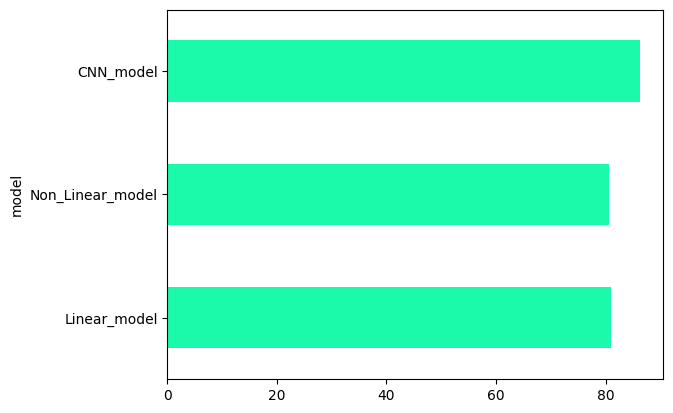

In [30]:
df = compare_model_result.set_index("model")["Accuracy"]
plt.xlabel("Accuracy")
plt.ylabel("Model")
df.plot(kind="barh", color = "#1BFAAA")

In [31]:
def prediction(data : list, # test_dataset
               model : torch.nn.Module,
               device : torch.device = device):
  model.eval()
  model.to(device)
  image_prediction = []
  with torch.inference_mode():
    for image in data:
      # add a extra dimension -> batch
      image = torch.unsqueeze(image,dim = 0).to(device)
      image_logit = model(image)
      image_pred_pro = torch.softmax(image_logit.squeeze(),dim = 0)
      image_prediction.append(image_pred_pro.cpu())

  return torch.stack(image_prediction) # stack's function -> list single element to tensor

In [32]:
import random

test_image = []
test_labels = []

for image,label in random.sample(list(test_dataset),k = 9):
  test_image.append(image)
  test_labels.append(label)

test = prediction(data = test_image,
                  model = cnn_model,
                  device = 'cpu')
test

tensor([[8.8229e-06, 9.9998e-01, 6.0471e-09, 9.4182e-06, 4.5345e-06, 3.0894e-08,
         8.2323e-07, 7.7224e-09, 2.1651e-08, 5.6406e-11],
        [4.8197e-04, 1.1971e-03, 1.3096e-01, 1.5968e-03, 8.2346e-01, 4.1382e-04,
         3.1638e-02, 1.2718e-05, 1.0174e-02, 6.5766e-05],
        [1.0707e-01, 5.1440e-02, 1.8837e-04, 7.8499e-01, 4.9504e-05, 3.3849e-05,
         5.5627e-02, 9.8765e-05, 4.5785e-04, 4.4356e-05],
        [1.1089e-06, 9.6586e-07, 1.2044e-05, 5.4925e-05, 7.6627e-07, 1.2013e-03,
         2.5713e-06, 9.9828e-01, 4.1233e-04, 3.6117e-05],
        [2.0970e-01, 3.5801e-04, 1.3105e-03, 5.4319e-03, 2.2791e-05, 2.0644e-05,
         7.8249e-01, 1.6680e-05, 6.4923e-04, 4.5846e-06],
        [6.9433e-01, 2.2328e-05, 1.8522e-04, 1.7228e-02, 2.8556e-05, 5.8404e-07,
         2.8815e-01, 2.5395e-06, 4.6592e-05, 1.2892e-06],
        [6.5829e-01, 3.5571e-04, 1.1587e-03, 1.1838e-01, 1.5354e-05, 4.0720e-05,
         2.2085e-01, 2.9433e-05, 6.6194e-04, 2.0968e-04],
        [2.7933e-04, 6.6913

In [33]:
test_pred_label = torch.argmax(test,dim = 1)
print(f"test_pred_label : {test_pred_label}")
print(f"test_label : {test_labels}")

test_pred_label : tensor([1, 4, 3, 7, 6, 0, 0, 7, 4])
test_label : [1, 4, 3, 7, 6, 0, 0, 7, 4]


In [34]:
type(test_pred_label)

torch.Tensor

In [35]:
test_labels = torch.tensor(test_labels)
type(test_labels)

torch.Tensor

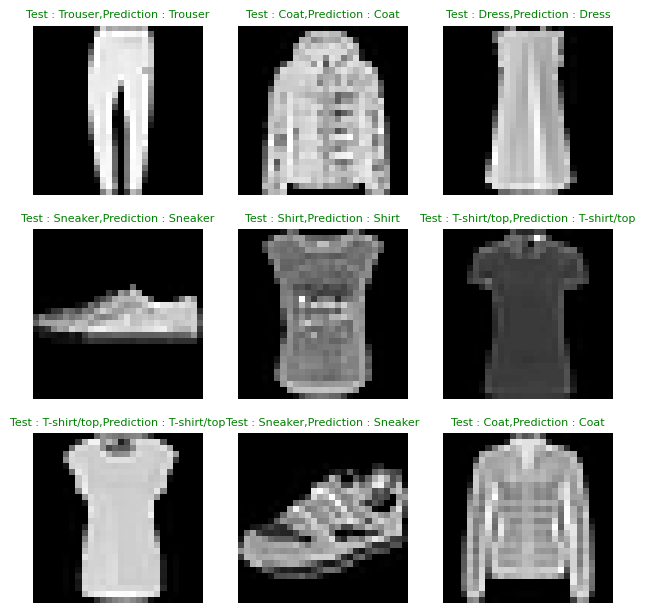

In [36]:
row, col = 3, 3
plt.figure(figsize=(7.5,7.5))

for i,image in enumerate(test_image):
  plt.subplot(row, col, i+1)
  test_label = train_class[test_labels[i]]
  pred_label = train_class[test_pred_label[i]]
  plt.imshow(image.squeeze(),cmap = "gray")
  title_text = f"Test : {test_label},Prediction : {pred_label}"
  plt.axis(False)
  if test_label == pred_label:
    plt.title(title_text, c="g",fontsize = 8)
  else:
    plt.title(title_text, c="g",fontsize = 8)

In [37]:
# we are using test_dataset's data to evaluate our prediction  -> confusionmatrics will use it to compare with our test_dataset
y_pred = []
cnn_model.eval()
with torch.inference_mode():
  for X,y in tqdm(test_dataloader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = cnn_model(X)
    y_pred_pro = torch.softmax(y_logit, dim = 1)
    y_pred_label = torch.argmax(y_pred_pro, dim = 1)
    y_pred.append(y_pred_label.cpu())       # matplotlib works cpu
y_pred_tensor = torch.cat(y_pred)           # cat means "concatenate"

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [38]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 4.7 MB/s eta 0:00:00


In [39]:
import torchmetrics, mlxtend
print(mlxtend.__version__)
print(torchmetrics.__version__)

0.22.0
1.3.1


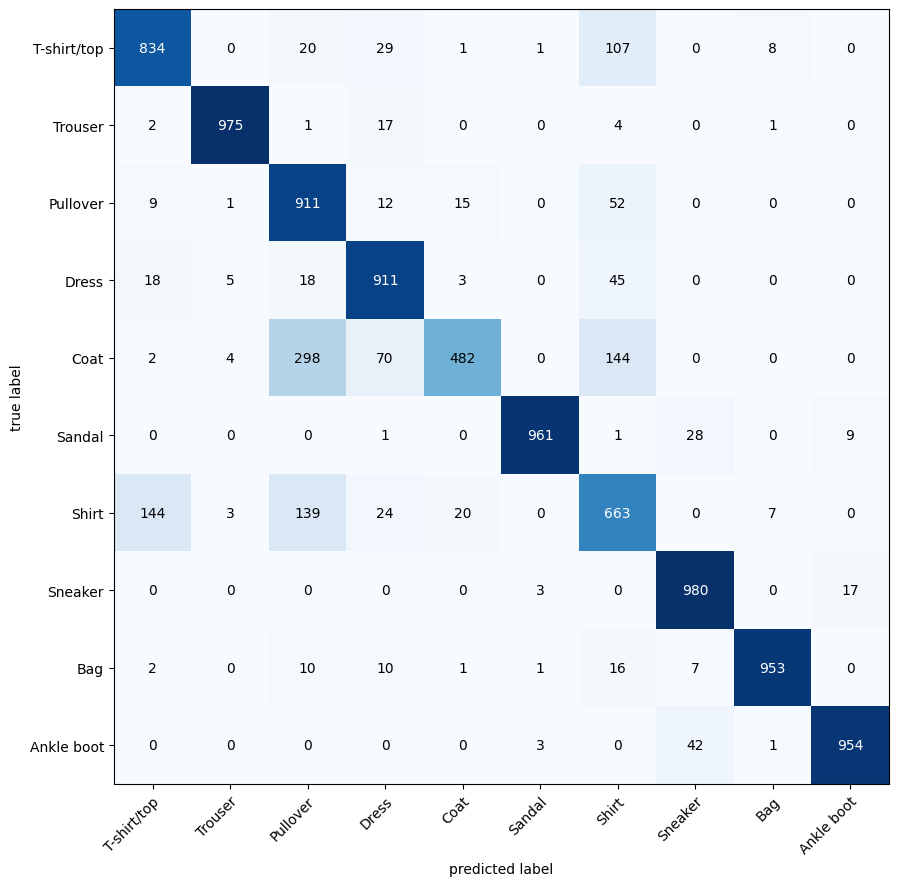

In [40]:
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix

confmax = ConfusionMatrix(num_classes = len(train_class), task="multiclass")
confmax_tensor = confmax(preds = y_pred_tensor,          # use testdata pass into cnn_model to get our prediction label -> lens is 10,000
                         target = test_dataset.targets)  # test_dataset original label -> len is 10,000
fig, ax = plot_confusion_matrix(
    conf_mat = confmax_tensor.numpy(), # matplotlib works numpy not tensor
    class_names= train_class,
    figsize = (10,12)
)

In [41]:
from pathlib import Path as path
model_path = path("model")
model_path.mkdir(parents = True,
                 exist_ok = True)

model_name = "CNN_ComputerVision"
model_path_name = model_path / model_name

print(f"Saving to {model_path_name}..")
torch.save(obj = cnn_model.state_dict(),
           f = model_path_name)

Saving to model/CNN_ComputerVision..
